# 2-Factor (2B) ANOVA (Training Day)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt
import statistics
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import skew, kurtosis
from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format

import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
df = pd.read_csv("Alzheimers Mice Data.csv")
df['AD_Status'] = df['AD_Status'].map({1: 'Transgenic', 2: 'Wild Type'})
df['Treatment'] = df['Treatment'].map({1: 'Drug 1', 2: 'Drug 2', 3: 'Drug 3', 4: 'Drug 4'})
display(df.head().style.hide(axis="index"))

AD_Status,Treatment,Training,Memory
Transgenic,Drug 1,12,10
Transgenic,Drug 1,15,12
Transgenic,Drug 1,13,13
Transgenic,Drug 1,12,10
Transgenic,Drug 1,14,13


In [3]:
df_train = df.drop(columns=['Memory'])
display(df_train.head().style.hide(axis="index"))

AD_Status,Treatment,Training
Transgenic,Drug 1,12
Transgenic,Drug 1,15
Transgenic,Drug 1,13
Transgenic,Drug 1,12
Transgenic,Drug 1,14


## Dataset and Problem
Mice are used in an experiment to test drugs that may prevent Alzheimer’s disease. Half the mice are transgenic – have been genetically modified to have Alzheimer’s disease. The other half of the mice are “wild type” – they have not been modified in any way, and are considered free of Alzheimer’s disease. These two categorizations will be represented as AD status. The mice are assigned to treatment conditions and given one of four drugs, then tested on memory using a maze. The number of errors made in the maze is recorded for the Training Day and the Memory Day.

A two-way ANOVA will be used to determine whether there is an interaction effect between two independent variables (AD status and Treatment) on a continuous dependent variable (training day errors).

## Hypotheses
\$ H_0 \$: There is no significant interaction effect on the number of training day errors between AD status and drug treatment. \
\$ H_A \$: There is a significant interaction effect on the number of training day errors between AD status and drug treatment.

## Assumptions
### Assumption 1: You have one dependent variable that is measured at the continuous level.
**Remark:** The dependent variable *Training* is measured at the continuous level.

### Assumption 2: You have two independent variables where each independent variable consists of two or more categorical, independent groups
**Remark:** The independent variables, *AD_Status* and *Treatment*, are categorical variables. *AD_Status* has two independent groups (Transgenic and Wild Type) and *Treatment* has four independent groups (1, 2, 3, and 4). 

### Assumption 3: You should have independence of observations.
**Remark:** Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the groups themselves.

### Assumption 4: There should be no significant outliers in any cell of the design.

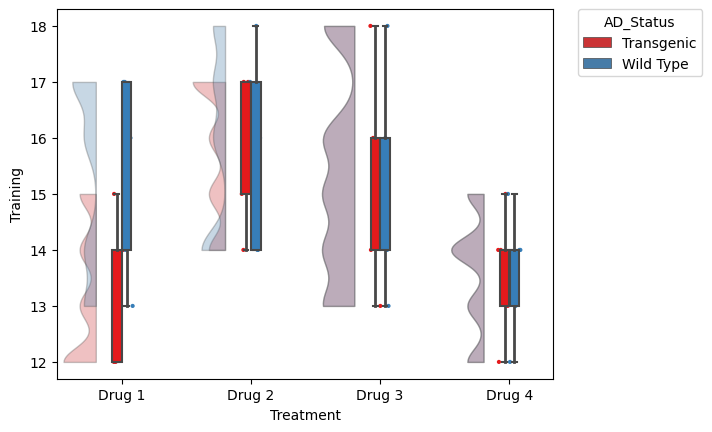

In [4]:
pt.RainCloud(data=df_train, x='Treatment', y='Training', hue='AD_Status',
             width_viol=0.5, alpha=0.3, palette='Set1', dodge=True)

plt.show()

**Remark:** By visual inspection of the boxplots, there are no significant outliers in any group.

### Assumption 5: The distribution of the dependent variable (residuals) should be approximately normally distributed in every cell of the design.

In [5]:
df_grouped = df_train.groupby(['AD_Status', 'Treatment'])['Training']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Min = 'min', Max = 'max', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (gender, education), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(gender, education)] = (stat, p_value)

shapiro = pd.DataFrame(results).transpose().rename(columns={0:'Shapiro', 1:'p-value'})
table_df = pd.concat([desc,skew_stderror, kurtosis, kurt_stderror, shapiro], axis=1)
table_df


Valid   Mean    SD  Min  Max  Skewness  \
Transgenic Drug 1      5 13.200 1.304   12   15     0.541   
           Drug 2      5 15.800 1.304   14   17    -0.541   
           Drug 3      5 15.200 1.924   13   18     0.590   
           Drug 4      5 13.600 1.140   12   15    -0.405   
Wild Type  Drug 1      5 15.400 1.817   13   17    -0.567   
           Drug 2      5 15.800 1.789   14   18     0.052   
           Drug 3      5 15.200 1.924   13   18     0.590   
           Drug 4      5 13.600 1.140   12   15    -0.405   

                   Std. Error of Skewness  Kurtosis  Std. Error of Kurtosis  \
Transgenic Drug 1                   0.913    -1.488                   2.000   
           Drug 2                   0.913    -1.488                   2.000   
           Drug 3                   0.913    -0.022                   2.000   
           Drug 4                   0.913    -0.178                   2.000   
Wild Type  Drug 1                   0.913    -2.231                   2.000   
           Drug 2                   0.913    -2.324                   2.000   
           Drug 3                   0.913    -0.022                   2.000   
           Drug 4                   0.913    -0.178                   2.000   

                   Shapiro  p-value  
Transgenic Drug 1    0.902    0.421  
           Drug 2    0.902    0.421  
           Drug 3    0.979    0.928  
           Drug 4    0.961    0.814  
Wild Type  Drug 1    0.867    0.254  
           Drug 2    0.894    0.377  
           Drug 3    0.979    0.928  
           Drug 4    0.961    0.814

**Remark:** As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the table.

### Assumption 6: The variance of the dependent variable (residuals) should be equal in every cell of the design.

In [6]:
groups = []
for edu_level in df['Treatment'].unique():
    for gender in df['AD_Status'].unique():
        group_data = df[(df['Treatment'] == edu_level) & (df['AD_Status'] == gender)]['Training']
        groups.append(group_data)

stat_levene, p_levene = levene(*groups)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [len(df['Treatment'].unique()) * len(df['AD_Status'].unique()) - 1],
    'df2': [len(df) - len(df['Treatment'].unique()) * len(df['AD_Status'].unique())],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

title_levene = '<h4 style="text-align: left;">Test for Equality of Variances (Levene\'s Test)</h4>'
display(HTML(title_levene))
display(levene_df.style.hide(axis="index"))

F,df1,df2,p
0.435000,7,32,0.873000


**Remark:** Since \$ p = 0.873 > 0.05 \$ by the Levene's test, then the variances for each combination of the groups of AD_Status and Treatment are homogeneous.

## Computation

#### Welch's ANOVA

In [7]:
welch_model = ols('Training ~ Treatment', data=df_train).fit()
welch_results = anova_lm(welch_model, typ=2)

welch_results

,sum_sq,df,F,PR(>F)
Treatment,28.275,3.000,3.700,0.020
Residual,91.700,36.000,NaN,NaN


**Remark:** Since \$ p = 0.020 > 0.005 \$, then there is no significant difference in the number of training day errors per drug treatment.

In [8]:
anova = pg.anova(dv='Training', between = ['AD_Status', 'Treatment'], data=df_train)
anova = anova.replace(['Residual', np.nan], ['Error', ''])
display(HTML("""<h5>Two-Way ANOVA</h5>"""), anova)

,Source,SS,DF,MS,F,p-unc,np2
0,AD_Status,3.025,1,3.025,1.216,0.278,0.037
1,Treatment,28.275,3,9.425,3.789,0.020,0.262
2,AD_Status * Treatment,9.075,3,3.025,1.216,0.320,0.102
3,Error,79.600,32,2.487,,,


**Remark:** The analysis revealed a significant main effect of Treatment on the number of training day errors, F(3, 32) = 3.789, p = 0.020, η²p = 0.262, indicating that the drug treatment levels differ in their effect on errors. This stands in contrast with the insignificant effect as shown by the Welch ANOVA, showing that the treatment's effect became significant when the interaction with AD Status was considered. However, neither AD Status (F(1, 32) = 1.216, p = 0.278, η²p = 0.037) nor the interaction between AD Status and Treatment (F(3, 32) = 1.216, p = 0.320, η²p = 0.102) had significant effects on the number of errors. Therefore, an analysis of the simple main effects for treatment will be conducted, with statistical significance determined using a Bonferroni adjustment and considered significant at the p < .025 level.

## Results of Simple Main Effects

### Simple Main Effects - Treatment

In [11]:
results = {}

alpha_adjusted = 0.025

for ad_status in df['AD_Status'].unique():
    df_ad_status = df[df['AD_Status'] == ad_status]
    
    model = ols('Training ~ C(Treatment)', data=df_ad_status).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    F_value = anova_table.loc['C(Treatment)', 'F']
    p_value = anova_table.loc['C(Treatment)', 'PR(>F)']
    
    significant = p_value < alpha_adjusted
    
    results[ad_status] = {'Sum of Squares': anova_table.loc['C(Treatment)', 'sum_sq'],
                       'df': int(anova_table.loc['C(Treatment)', 'df']),
                       'Mean Square': anova_table.loc['C(Treatment)', 'sum_sq'] / anova_table.loc['C(Treatment)', 'df'],
                       'F': F_value,
                       'p': p_value,
                       'Significant (<0.025)': significant}

results_df = pd.DataFrame(results).T
title_simpgen = '<h4 style="text-align: left;">Simple Main Effects - Treatment</h4>'
display(HTML(title_simpgen))
results_df

,Sum of Squares,df,Mean Square,F,p,Significant (<0.025)
Transgenic,23.350,3,7.783,3.706,0.034,False
Wild Type,14.000,3,4.667,1.623,0.223,False


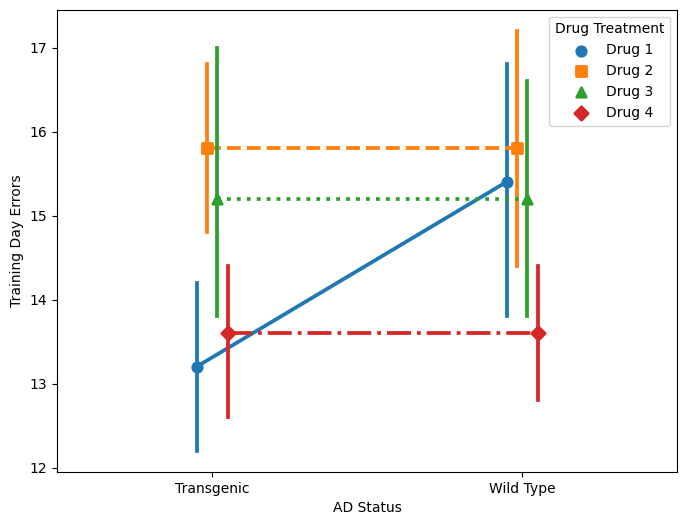

In [10]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='AD_Status', y='Training', hue='Treatment', data=df_train, dodge=True, markers=['o', 's', '^', 'D'], linestyles=['-', '--', ':', '-.'])

plt.xlabel("AD Status")
plt.ylabel("Training Day Errors")
plt.legend(title='Drug Treatment')
plt.show()

**Remark:** A simple main effects analysis was performed to examine the influence of treatment type on mice with different AD status, specifically Transgenic and Wild Type. For the Transgenic mice, the analysis revealed no statistically significant effect, F(3, df)=3.706, 𝑝=0.034, which did not meet the Bonferroni-adjusted alpha level of 0.025. Similarly, for the Wild Type mice, no significant effect was found, F(3, df)=1.623, 𝑝=0.223, indicating that treatment type did not have a notable impact on AD status within these groups.

## Post Hoc Comparisons – AD_Status*Treatment

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df['Group'] = df['Treatment'].astype(str) + ' - ' + df['AD_Status'].astype(str)

tukey = pairwise_tukeyhsd(endog=df['Training'], groups=df['Group'], alpha=0.05)
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

tukey_results['SE'] = np.sqrt((tukey_results['meandiff'] ** 2) / len(df))
tukey_results['t'] = tukey_results['meandiff'] / tukey_results['SE']

tukey_results.rename(columns={
    'group1': 'Group 1',
    'group2': 'Group 2',
    'meandiff': 'Mean Difference',
    'lower': 'Lower CI',
    'upper': 'Upper CI',
    'p-adj': 'p_tukey'
}, inplace=True)

tukey_results = tukey_results[['Group 1', 'Group 2', 'Mean Difference', 'Lower CI', 'Upper CI', 'SE', 't', 'p_tukey']]

title_posthoc = '<h4 style="text-align: left;">Post Hoc Comparisons - Treatment and AD Status</h4>'
title_ci = '<h5 style="text-align: left;">95% CI for Mean Difference</h5>'

display(HTML(title_posthoc))
display(HTML(title_ci))
display(tukey_results.style.hide(axis="index"))

Group 1,Group 2,Mean Difference,Lower CI,Upper CI,SE,t,p_tukey
Drug 1 - Transgenic,Drug 1 - Wild Type,2.200000,-1.031200,5.431200,0.347851,6.324555,0.375200
Drug 1 - Transgenic,Drug 2 - Transgenic,2.600000,-0.631200,5.831200,0.411096,6.324555,0.190600
Drug 1 - Transgenic,Drug 2 - Wild Type,2.600000,-0.631200,5.831200,0.411096,6.324555,0.190600
Drug 1 - Transgenic,Drug 3 - Transgenic,2.000000,-1.231200,5.231200,0.316228,6.324555,0.494400
Drug 1 - Transgenic,Drug 3 - Wild Type,2.000000,-1.231200,5.231200,0.316228,6.324555,0.494400
Drug 1 - Transgenic,Drug 4 - Transgenic,0.400000,-2.831200,3.631200,0.063246,6.324555,0.999900
Drug 1 - Transgenic,Drug 4 - Wild Type,0.400000,-2.831200,3.631200,0.063246,6.324555,0.999900
Drug 1 - Wild Type,Drug 2 - Transgenic,0.400000,-2.831200,3.631200,0.063246,6.324555,0.999900
Drug 1 - Wild Type,Drug 2 - Wild Type,0.400000,-2.831200,3.631200,0.063246,6.324555,0.999900
Drug 1 - Wild Type,Drug 3 - Transgenic,-0.200000,-3.431200,3.031200,0.031623,-6.324555,1.000000


In [13]:
describe_stats = []

for group_name, group_data in df.groupby(['Treatment', 'AD_Status']):
    training = group_data['Training']
    
    mean = training.mean()
    std_dev = training.std()
    count = training.count()
    se = std_dev / np.sqrt(count)
    cv = (std_dev / mean)
    
    describe_stats.append({
        'AD Status - Drug Treatment': f"{group_name[1]} - {group_name[0]}",
        'N': count,
        'Mean': mean,
        'SD': std_dev,
        'SE': se,
        'Coefficient of Variation': cv,
    })

describe_table = pd.DataFrame(describe_stats).set_index('AD Status - Drug Treatment')

describe_table = describe_table.style.format({
    'Mean': '{:.3f}',
    'SD': '{:.3f}',
    'SED': '{:.3f}',
    'Coefficient of Variation': '{:.3f}',
})

title_describe = '<h4 style="text-align: left;">Descriptives - Training Day Errors</h4>'
display(HTML(title_describe))
display(describe_table)

,N,Mean,SD,SE,Coefficient of Variation
AD Status - Drug Treatment,,,,,
Transgenic - Drug 1,5,13.200,1.304,0.583095,0.099
Wild Type - Drug 1,5,15.400,1.817,0.812404,0.118
Transgenic - Drug 2,5,15.800,1.304,0.583095,0.083
Wild Type - Drug 2,5,15.800,1.789,0.800000,0.113
Transgenic - Drug 3,5,15.200,1.924,0.860233,0.127
Wild Type - Drug 3,5,15.200,1.924,0.860233,0.127
Transgenic - Drug 4,5,13.600,1.140,0.509902,0.084
Wild Type - Drug 4,5,13.600,1.140,0.509902,0.084


**Remark:** Pairwise comparisons were conducted for each simple main effect, with Tukey-adjusted p-values and 95% confidence intervals reported. Scores are to be presented as mean ± standard deviation. For the Transgenic group, the mean number of training day errors were 13.200 ± 1.304 for Drug 1, 15.800 ± 1.304 for Drug 2, 15.200 ± 1.924 for Drug 3, and 13.600 ± 1.140 for Drug 4. No significant differences were observed between the treatments for Transgenic mice.

For the Wild Type group, the mean number of training day errors were 15.400 ± 1.817 for Drug 1, 15.800 ± 1.789 for Drug 2, 15.200 ± 1.924 for Drug 3, and 13.600 ± 1.140 for Drug 4. Similarly, no significant differences were found between treatments for Wild Type mice.

---
# 2-Factor (2B) ANOVA (Memory Day)

In [14]:
df_memory = df.drop(columns=['Training', 'Group'])
display(df_memory.head().style.hide(axis="index"))

AD_Status,Treatment,Memory
Transgenic,Drug 1,10
Transgenic,Drug 1,12
Transgenic,Drug 1,13
Transgenic,Drug 1,10
Transgenic,Drug 1,13


## Dataset and Problem
Mice are used in an experiment to test drugs that may prevent Alzheimer’s disease. Half the mice are transgenic – have been genetically modified to have Alzheimer’s disease. The other half of the mice are “wild type” – they have not been modified in any way, and are considered free of Alzheimer’s disease. These two categorizations will be represented as AD status. The mice are assigned to treatment conditions and given one of four drugs, then tested on memory using a maze. The number of errors made in the maze is recorded for the Training Day and the Memory Day.

A two-way ANOVA will be used to determine whether there is an interaction effect between two independent variables (AD status and Treatment) on a continuous dependent variable (memory day errors).

## Hypotheses
\$ H_0 \$: There is no significant interaction effect on the number of memory day errors between AD status and drug treatment. \
\$ H_A \$: There is a significant interaction effect on the number of memory day errors between AD status and drug treatment.

## Assumptions
### Assumption 1: You have one dependent variable that is measured at the continuous level.
**Remark:** The dependent variable *Memory* is measured at the continuous level.

### Assumption 2: You have two independent variables where each independent variable consists of two or more categorical, independent groups
**Remark:** The independent variables, *AD_Status* and *Treatment*, are categorical variables. *AD_Status* has two independent groups (Transgenic and Wild Type) and *Treatment* has four independent groups (1, 2, 3, and 4). 

### Assumption 3: You should have independence of observations.
**Remark:** Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the groups themselves.

### Assumption 4: There should be no significant outliers in any cell of the design.

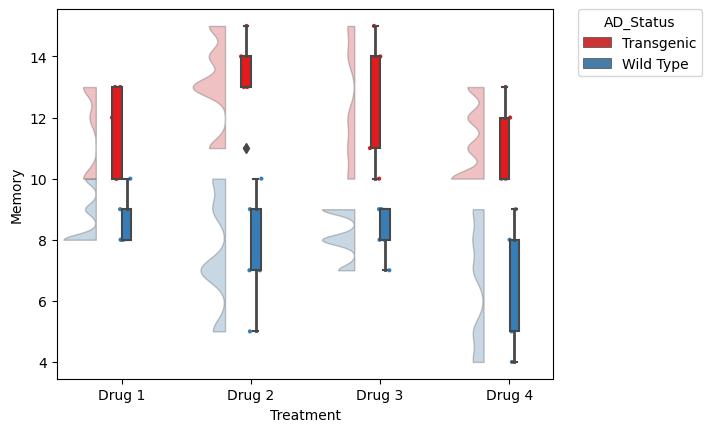

In [15]:
pt.RainCloud(data=df_memory, x='Treatment', y='Memory', hue='AD_Status',
             width_viol=0.5, alpha=0.3, palette='Set1', dodge=True)

plt.show()

As observed from the boxplots, there is one outlier in the Transgenic group for Drug 2 Treatment. We will now proceed to removing this as to not skew the results of the ANOVA.

In [16]:
df_memory = df_memory.drop(index=9)

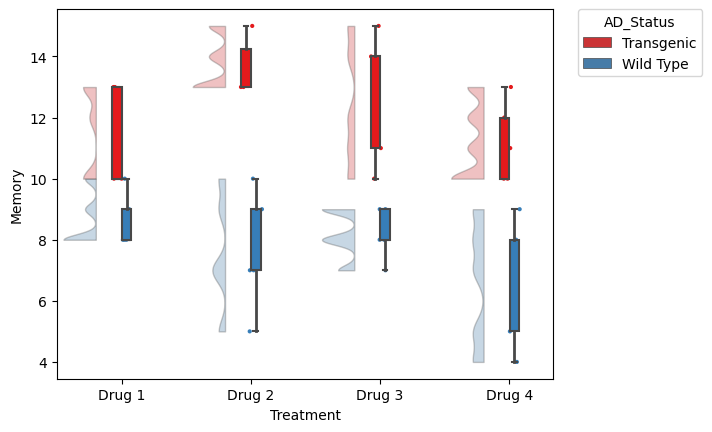

In [17]:
pt.RainCloud(data=df_memory, x='Treatment', y='Memory', hue='AD_Status',
             width_viol=0.5, alpha=0.3, palette='Set1', dodge=True)

plt.show()

**Remark:** There are no more significant outliers in all groups.

### Assumption 5: The distribution of the dependent variable (residuals) should be approximately normally distributed in every cell of the design.

In [18]:
from scipy.stats import shapiro

df_grouped = df_memory.groupby(['AD_Status', 'Treatment'])['Memory']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Min = 'min', Max = 'max', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (gender, education), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(gender, education)] = (stat, p_value)
    
shapiro_results = pd.DataFrame(results).transpose().rename(columns={0: 'Shapiro', 1: 'p-value'})
table_df = pd.concat([desc, skew_stderror, kurtosis, kurt_stderror, shapiro_results], axis=1)
table_df

Valid   Mean    SD  Min  Max  Skewness  \
Transgenic Drug 1      5 11.600 1.517   10   13    -0.315   
           Drug 2      4 13.750 0.957   13   15     0.855   
           Drug 3      5 12.400 2.074   10   15     0.236   
           Drug 4      5 11.200 1.304   10   13     0.541   
Wild Type  Drug 1      5  8.600 0.894    8   10     1.258   
           Drug 2      5  7.600 1.949    5   10    -0.081   
           Drug 3      5  8.200 0.837    7    9    -0.512   
           Drug 4      5  6.600 2.074    4    9    -0.236   

                   Std. Error of Skewness  Kurtosis  Std. Error of Kurtosis  \
Transgenic Drug 1                   0.913    -3.081                   2.000   
           Drug 2                   1.014    -1.289                   2.619   
           Drug 3                   0.913    -1.963                   2.000   
           Drug 4                   0.913    -1.488                   2.000   
Wild Type  Drug 1                   0.913     0.313                   2.000   
           Drug 2                   0.913    -0.817                   2.000   
           Drug 3                   0.913    -0.612                   2.000   
           Drug 4                   0.913    -1.963                   2.000   

                   Shapiro  p-value  
Transgenic Drug 1    0.803    0.086  
           Drug 2    0.863    0.272  
           Drug 3    0.952    0.754  
           Drug 4    0.902    0.421  
Wild Type  Drug 1    0.771    0.046  
           Drug 2    0.953    0.758  
           Drug 3    0.881    0.314  
           Drug 4    0.952    0.754

**Remark:** As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the table except Wild Type - Drug 1 which has p=0.046<0.05. Since the normality assumption is violated, we will try log-transforming the data and assess again if normality is reached.

In [19]:
df_memory['Memory_log'] = np.log(df_memory['Memory'])
display(df_memory.head().style.hide(axis="index"))

AD_Status,Treatment,Memory,Memory_log
Transgenic,Drug 1,10,2.302585
Transgenic,Drug 1,12,2.484907
Transgenic,Drug 1,13,2.564949
Transgenic,Drug 1,10,2.302585
Transgenic,Drug 1,13,2.564949


In [20]:
from scipy.stats import shapiro

df_grouped = df_memory.groupby(['AD_Status', 'Treatment'])['Memory_log']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Min = 'min', Max = 'max', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (gender, education), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(gender, education)] = (stat, p_value)
    
shapiro_results = pd.DataFrame(results).transpose().rename(columns={0: 'Shapiro', 1: 'p-value'})
table_df = pd.concat([desc, skew_stderror, kurtosis, kurt_stderror, shapiro_results], axis=1)
table_df

Valid  Mean    SD   Min   Max  Skewness  \
Transgenic Drug 1      5 2.444 0.133 2.303 2.565    -0.361   
           Drug 2      4 2.619 0.069 2.565 2.708     0.796   
           Drug 3      5 2.506 0.167 2.303 2.708     0.066   
           Drug 4      5 2.411 0.115 2.303 2.565     0.430   
Wild Type  Drug 1      5 2.148 0.101 2.079 2.303     1.186   
           Drug 2      5 2.000 0.269 1.609 2.303    -0.530   
           Drug 3      5 2.100 0.104 1.946 2.197    -0.668   
           Drug 4      5 1.844 0.337 1.386 2.197    -0.544   

                   Std. Error of Skewness  Kurtosis  Std. Error of Kurtosis  \
Transgenic Drug 1                   0.913    -3.108                   2.000   
           Drug 2                   1.014    -1.597                   2.619   
           Drug 3                   0.913    -1.902                   2.000   
           Drug 4                   0.913    -1.765                   2.000   
Wild Type  Drug 1                   0.913    -0.074                   2.000   
           Drug 2                   0.913    -0.041                   2.000   
           Drug 3                   0.913    -0.158                   2.000   
           Drug 4                   0.913    -1.666                   2.000   

                   Shapiro  p-value  
Transgenic Drug 1    0.797    0.076  
           Drug 2    0.864    0.275  
           Drug 3    0.958    0.797  
           Drug 4    0.903    0.424  
Wild Type  Drug 1    0.773    0.048  
           Drug 2    0.941    0.673  
           Drug 3    0.878    0.302  
           Drug 4    0.935    0.633

As observed from the table, log-transforming did not make Wild Type - Drug 1 normally distributed. Hence, this method won't work for this dataset. We will now drop the 'Memory_log' column.

In [23]:
df_memory = df_memory.drop(columns=['Memory_log'])
display(df_memory.head().style.hide(axis="index"))

AD_Status,Treatment,Memory
Transgenic,Drug 1,10
Transgenic,Drug 1,12
Transgenic,Drug 1,13
Transgenic,Drug 1,10
Transgenic,Drug 1,13


**Remark:** Since normality is violated, then we will have to note in our results that the data deviates from normality by 0.04 in p-value.

### Assumption 6: The variance of the dependent variable (residuals) should be equal in every cell of the design.

In [24]:
groups = []
for edu_level in df['Treatment'].unique():
    for gender in df['AD_Status'].unique():
        group_data = df[(df['Treatment'] == edu_level) & (df['AD_Status'] == gender)]['Memory']
        groups.append(group_data)

stat_levene, p_levene = levene(*groups)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [len(df['Treatment'].unique()) * len(df['AD_Status'].unique()) - 1],
    'df2': [len(df) - len(df['Treatment'].unique()) * len(df['AD_Status'].unique())],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

title_levene = '<h4 style="text-align: left;">Test for Equality of Variances (Levene\'s Test)</h4>'
display(HTML(title_levene))
display(levene_df.style.hide(axis="index"))

F,df1,df2,p
0.827000,7,32,0.572000


**Remark:** Since \$ p = 0.572 > 0.05 \$ by the Levene's test, then the variances for each combination of the groups of AD_Status and Treatment are homogeneous.

## Computation

#### Welch's ANOVA

In [25]:
welch_model = ols('Memory ~ Treatment', data=df_memory).fit()
welch_results = anova_lm(welch_model, typ=2)

welch_results

,sum_sq,df,F,PR(>F)
Treatment,13.690,3.000,0.575,0.635
Residual,277.900,35.000,NaN,NaN


**Remark:** Since \$ p = 0.635 > 0.005 \$, then there is no significant difference in the number of memory day errors per drug treatment.

In [26]:
anova = pg.anova(dv='Memory', between = ['AD_Status', 'Treatment'], data=df_memory)
anova = anova.replace(['Residual', np.nan], ['Error', ''])
display(HTML("""<h5>Two-Way ANOVA</h5>"""), anova)

,Source,SS,DF,MS,F,p-unc,np2
0,AD_Status,191.660,1.000,191.660,79.912,0.000,0.720
1,Treatment,16.036,3.000,5.345,2.229,0.105,0.177
2,AD_Status * Treatment,11.890,3.000,3.963,1.652,0.198,0.138
3,Error,74.350,31.000,2.398,,,


**Remark:** The analysis revealed that AD Status, Treatment, and AD_Status*Treatment together do not have significant interaction effects on the number of memory day errors. Hence, we accept the null hypothesis. Since there are no interaction effects, then the simple main effects are equal and we can, therefore, consider them together as one. That is, report the effect of drug treatment on the number of memory day errors, ignoring AD status.

#### One Way ANOVA

In [29]:
dropped_ad = df_memory.drop(columns=['AD_Status'])
display(dropped_ad.head().style.hide(axis="index"))

Treatment,Memory
Drug 1,10
Drug 1,12
Drug 1,13
Drug 1,10
Drug 1,13


In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Memory ~ Treatment', data=dropped_ad).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table = anova_table.rename(columns={
    'sum_sq': 'Type III Sum of Squares',
    'df': 'df',
    'F': 'F',
    'PR(>F)': 'p'
})

anova_table['Mean Square'] = anova_table['Type III Sum of Squares'] / anova_table['df']
anova_table['η²p'] = anova_table.loc['Treatment', 'Type III Sum of Squares'] / (anova_table.loc['Residual', 'Type III Sum of Squares'] + anova_table.loc['Treatment', 'Type III Sum of Squares'])

anova_table = anova_table.drop('Intercept', errors='ignore')
anova_table.loc['Residual', ['F', 'p', 'η²p']] = None
anova_table = anova_table[['Type III Sum of Squares', 'df', 'Mean Square', 'F', 'p', 'η²p']]

anova_table = anova_table.style.format({
    'df': '{:.0f}',
    'p': '{:.3f}',
    'F': '{:.3f}',
    'η²p': '{:.2f}'
})

title_anova = '<h4 style="text-align: left;">ANOVA - Memory</h4>'
display(HTML(title_anova))
anova_table

,Type III Sum of Squares,df,Mean Square,F,p,η²p
Treatment,13.689744,3,4.563248,0.575,0.635,0.05
Residual,277.900000,35,7.940000,nan,nan,nan


In [37]:
describe_stats = []

for group_name, group_data in dropped_ad.groupby('Treatment'):
    memory = group_data['Memory']

    mean = memory.mean()
    std_dev = memory.std()
    count = memory.count()
    
    describe_stats.append({
        'Treatment': group_name,
        'Mean': mean,
        'SD': std_dev,
        'N': count,
    })

describe_table = pd.DataFrame(describe_stats).set_index('Treatment')

describe_table = describe_table.style.format({
    'Mean': '{:.3f}',
    'SD': '{:.3f}',
})

title_describe = '<h4 style="text-align: left;">Descriptives - Memory</h4>'
display(HTML(title_describe))
display(describe_table)

,Mean,SD,N
Treatment,,,
Drug 1,10.100,1.969,10
Drug 2,10.333,3.571,9
Drug 3,10.300,2.669,10
Drug 4,8.900,2.923,10


In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dropped_ad['Memory'], groups=dropped_ad['Treatment'], alpha=0.05)
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

tukey_results['SE'] = np.sqrt((tukey_results['meandiff'] ** 2) / len(df))
tukey_results['t'] = tukey_results['meandiff'] / tukey_results['SE']

tukey_results.rename(columns={
    'group1': 'Group 1',
    'group2': 'Group 2',
    'meandiff': 'Mean Difference',
    'lower': 'Lower CI',
    'upper': 'Upper CI',
    'p-adj': 'p_tukey'
}, inplace=True)

tukey_results = tukey_results[['Group 1', 'Group 2', 'Mean Difference', 'Lower CI', 'Upper CI', 'SE', 't', 'p_tukey']]
title_posthoc = '<h4 style="text-align: left;">Post Hoc Comparisons - Treatment</h4>'
title_ci = '<h5 style="text-align: left;">95% CI for Mean Difference</h4>'

display(HTML(title_posthoc))
display(HTML(title_ci))
display(tukey_results.style.hide(axis="index"))

Group 1,Group 2,Mean Difference,Lower CI,Upper CI,SE,t,p_tukey
Drug 1,Drug 2,0.233300,-3.258300,3.725000,0.036888,6.324555,0.997900
Drug 1,Drug 3,0.200000,-3.198500,3.598500,0.031623,6.324555,0.998500
Drug 1,Drug 4,-1.200000,-4.598500,2.198500,0.189737,-6.324555,0.777000
Drug 2,Drug 3,-0.033300,-3.525000,3.458300,0.005265,-6.324555,1.000000
Drug 2,Drug 4,-1.433300,-4.925000,2.058300,0.226625,-6.324555,0.687600
Drug 3,Drug 4,-1.400000,-4.798500,1.998500,0.221359,-6.324555,0.685300


**Remark:** A one-way ANOVA was conducted to determine if the number of memory day errors was different across different drugs treatment. Note that the data failed the assumption of normality by 0.04 in p-value. Mice were classified into four drug treatments: Drug 1 (n = 10), Drug 2 (n = 10), Drug 3 (n = 10), and Drug 4 (n = 10). There were outliers as assessed by visual inspection of the boxplots, but they were removed; data was not normally distributed for all groups as disclaimed; and there was homogeneity of variances, as assessed by Levene's test of homogeneity of variances (p = .572). Data is presented as mean ± standard deviation. The number of memory day errors was not statistically significantly different between the different treatment groups, F(3, 35) = 0.575, p = 0.635, η²p = 0.05. Memory day errors increased from Drug 4 (M = 8.900, SD = 2.923) to Drug 1 (M = 10.100, SD = 1.969) then Drug 31 (M = 10.300, SD = 2.669) and Drug 2 (M = 10.333, SD = 3.571) groups, in that order.

Tukey post hoc analysis revealed thanone of the drug treatments produced any statistically significant effects on the number of memory day errors.t.